# Solving a QUBO problem
Solve a Quadratic Unconstrained Binary Optimization (QUBO) problem using Rydberg atoms in analog mode.

Of interest for, e.g.:
- Finance [cf. Leclerc _et al._, Phys. Rev. Research **5**, 043117 (2023)]
- Scheduling problems
- Graph-based problems

Formulation: given an $N \times N$ matrix $Q$, find vector $z \in \mathbb{Z}_2^n$ that minimizes
$$
f(z) = z^T Q z
$$

Let's use two algorithms: **quantum approximate optimization algorithm (QAOA)** and **adiabatic quantum computing**.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

Suppose we are given the following QUBO matrix $Q$:

In [64]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

This is a small problem, there are $2^5 = 32$ candidate solutions. We first check them manually:

In [65]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


### Embedding a QUBO onto an atomic register
How to choose atom positions $r_i$ such that the interaction matrix $U_{ij} = C_6/|r_i - r_j|^6$ approximates the off-diagonal elements of Q?

Try optimization:

In [66]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [67]:
shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

How did we do?

In [68]:
squareform(DigitalAnalogDevice.interaction_coeff / pdist(coords)**6)

array([[ 0.        , 19.73658076, 19.73658097,  5.42015839,  5.42015838],
       [19.73658076,  0.        , 20.67626392,  0.17675795,  0.85604562],
       [19.73658097, 20.67626392,  0.        ,  0.85604539,  0.17675797],
       [ 5.42015839,  0.17675795,  0.85604539,  0.        ,  0.32306654],
       [ 5.42015838,  0.85604562,  0.17675797,  0.32306654,  0.        ]])

In [69]:
Q - np.diag(np.diag(Q))

array([[ 0.        , 19.7365809 , 19.7365809 ,  5.42015853,  5.42015853],
       [19.7365809 ,  0.        , 20.67626392,  0.17675796,  0.85604541],
       [19.7365809 , 20.67626392,  0.        ,  0.85604541,  0.17675796],
       [ 5.42015853,  0.17675796,  0.85604541,  0.        ,  0.32306662],
       [ 5.42015853,  0.85604541,  0.17675796,  0.32306662,  0.        ]])

What a coincidence!

Let's look at the `Register`:

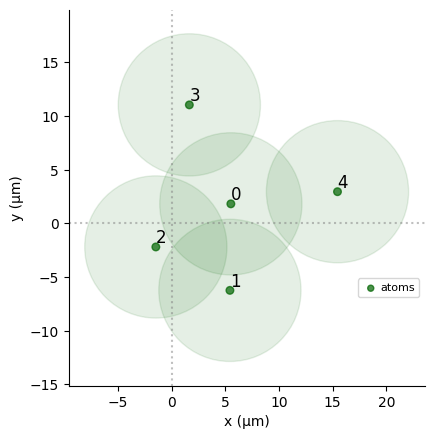

In [70]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

## Building the quantum algorithm 

We peprare the following Ising Hamiltonian $H_Q$:

$$ H_Q= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2} \sigma_i^z+\sum_{j \lt i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j. $$

In our example the interaction term perfectly represents the off-diagonal elements of $Q$. The next step is to prepare the ground-state of $H_Q$ to output the optimal bitstrings.

### QAOA
- All atoms are initially in the groundstate $|00\dots0\rangle$ of the `ground-rydberg` basis.
- Apply $p$ layers of alternating, non-commutative Hamiltonians. The first one, called the mixing Hamiltonian $H_M$, has $\Omega = 1$ rad/µs, and $\delta = 0$ rad/µs.
- The second Hamiltonian $H_Q$ has $\Omega =0$ rad/µs and $\delta = 1$ rad/µs.
- $H_M$ and $H_Q$ are applied turn in turn with parameters $\tau$ and $t$ respectively. A classical optimizer is then used to estimate the optimal parameters. 


New ingredient: the parametrized `Sequence` for easier optimization:

In [71]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

Once we have the parameters that we want to apply, we use the `.build()` method to assign these values into a `assigned_seq` sequence. It is this sequence which is simulated every time the quantum loop is called.

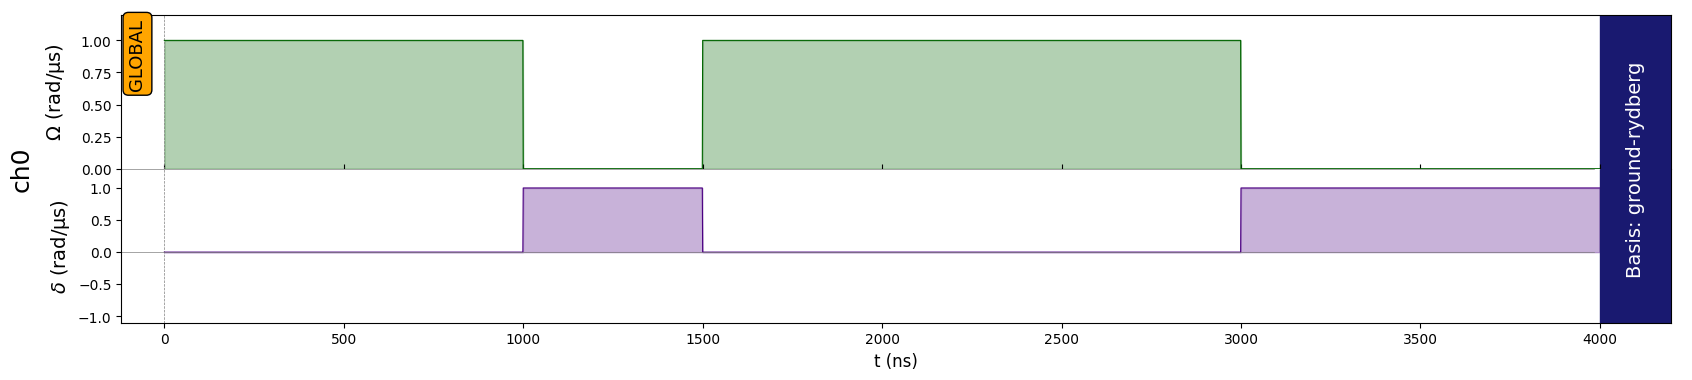

In [74]:
s = seq.build(t_list = [1, 1.5],
              s_list = [0.5, 1])
s.draw()

Experimentally, we can't access the state vector $|\psi\rangle$. Instead we take samples, here emulated using the built-in method `results.sample_final_state()`, in which we specify the number of samples desired (defaults to 1000).

In [78]:
def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [79]:
np.random.seed(123)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

Let's look at the samples, note it changes every time its run.

In [94]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])
example_dict

Counter({'00011': 251,
         '01010': 121,
         '01000': 114,
         '00100': 109,
         '00000': 105,
         '00101': 104,
         '10000': 57,
         '00010': 48,
         '00001': 43,
         '00111': 16,
         '01011': 13,
         '00110': 5,
         '10001': 4,
         '01001': 2,
         '10011': 2,
         '01101': 1,
         '01110': 1,
         '10010': 1,
         '10111': 1,
         '11000': 1,
         '11010': 1})

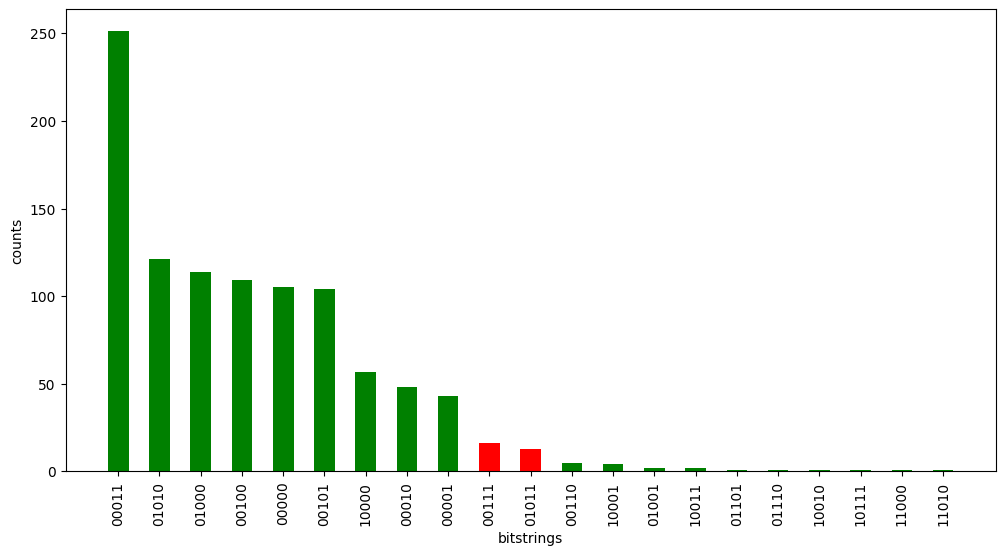

In [95]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()
    
plot_distribution(example_dict)

The bitstrings `01011` and `00111` (in red) correspond to the two optimal solutions (calculated at the beginning of the notebook). The goal of QAOA is to choregraph interferences between the basis states, in order to maximize the frequency of the optimal solution states. 

## Optimization 
Calculate the average (expectation value) of the cost function over a set of measurements:

In [96]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

get_cost(example_dict, Q)

-13.877957297939997

To perform a minimization loop, we define the following function that will be called at each step by SciPy. `*args` enables to pass the QUBO value, and `params` contains the trial value to score, which changes at each step.

In [97]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

### QAOA for depth $p = 2$
We now use a classical optimizer (`minimize`, from `scipy`) in order to find the best variational parameters. We repeat the optimization a number of times and select the parameters that yield the best approximation ratio.

In [98]:
scores = []
params = []

np.random.seed(42+2)
for repetition in range(10):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],  # Concatenate w/ numpy witchcraft 
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

Here's the sample we obtained using the optimal variational parameters:

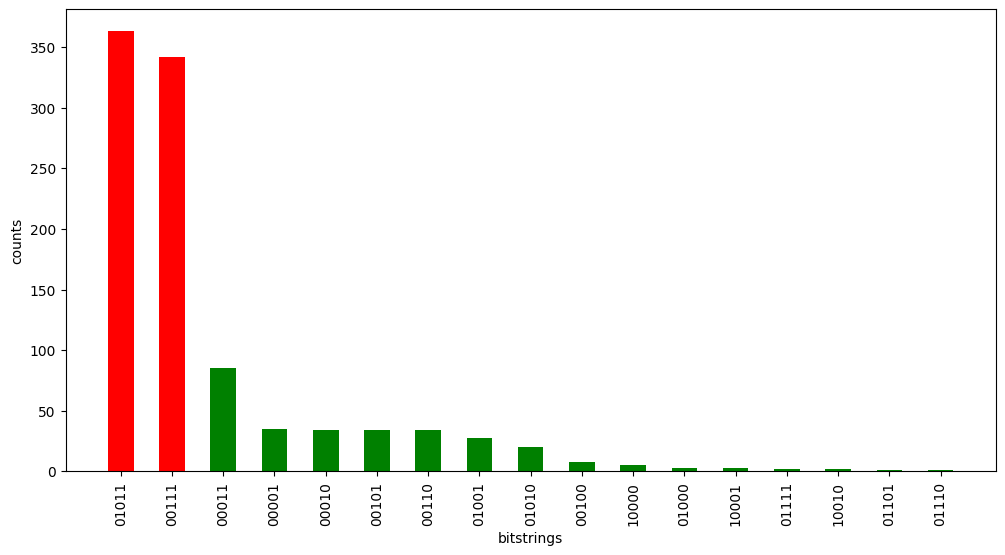

In [99]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)

However, using QAOA to solve the problem is not the best idea; it's difficult to yield a >90% quality solution without going to high depths of the QAOA, implying that the growing closed-loop optimization can rapidly become expensive, with no guarantee of convergence. We therefore propose another approach called the Quantum Adiabatic Algorithm (QAA). This fast, reliant and exclusively analog method shows optimal convergence to the solution.

## Adiabatic quantum computing
[Also see [Albash, Lidar, 2018](https://arxiv.org/pdf/1611.04471.pdf)]

The idea is to slowly evolve the system from an easy-to-prepare ground state to the ground state of $H_Q$. If done adiabatically, the system stays in the instantaneous ground state.

To ensure that we are not exciting the system to highly-excited states, we keep $\Omega \in [0, \Omega_{\text{max}}]$, and choose $\Omega_{\text{max}}$ as the median of the values of Q to ensures that the adiabatic path is efficient.

In our case, we continuously vary the parameters $\Omega(t), \delta(t)$ in time, starting with $\Omega(0)=0, \delta(0)<0$ and ending with $\Omega(0)=0, \delta>0$. The ground-state of $H(0)$ corresponds to the initial state $|00000\rangle$ and the ground-state of $H(t_f)$ corresponds to the ground-state of $H_Q$.

In [100]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

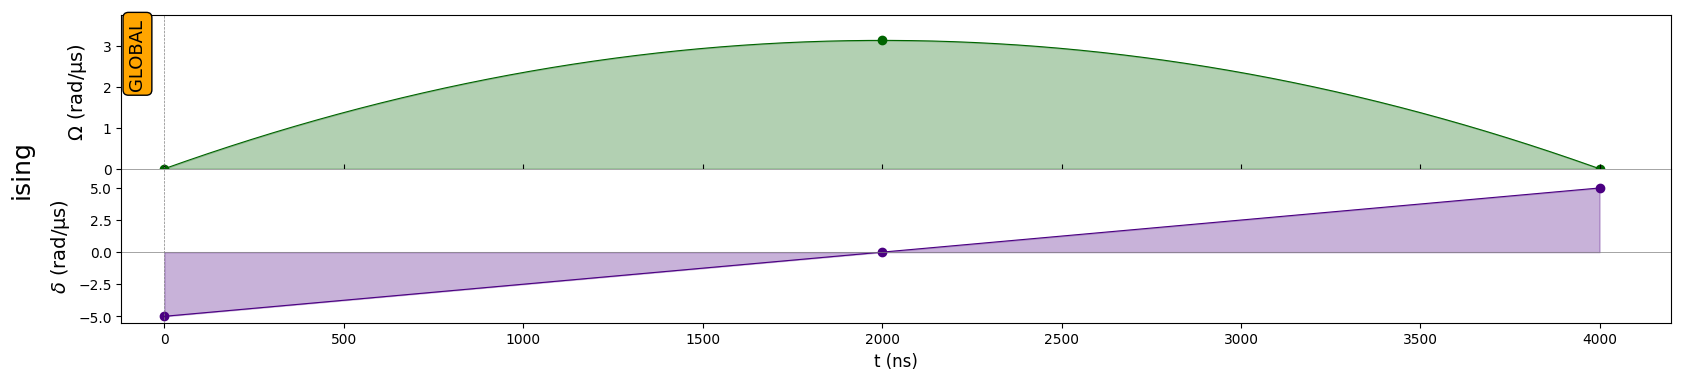

In [101]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [102]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

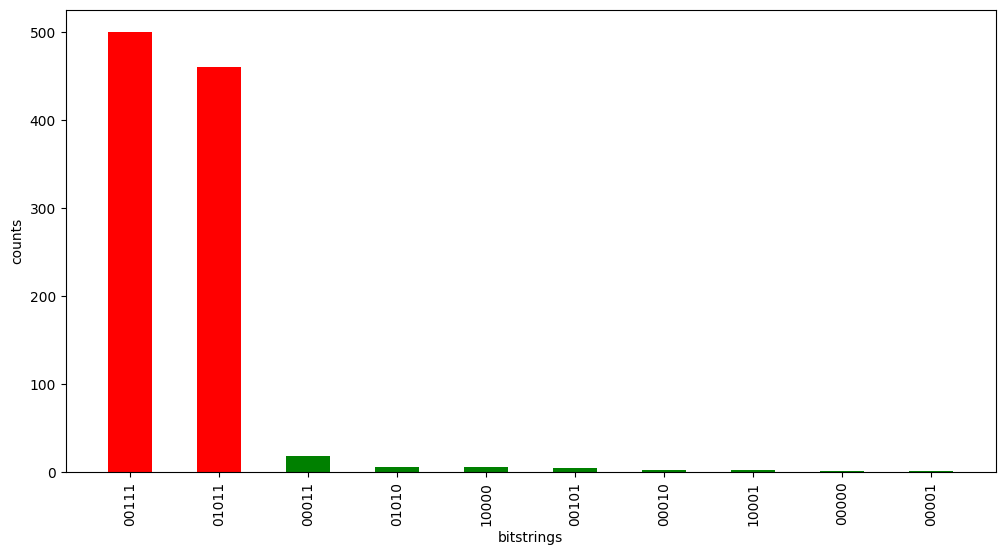

In [103]:
plot_distribution(count_dict)

See how fast and performant this method is! In only a few micro-seconds, we find an excellent solution.

### How does the time evolution affect the quality of the results?

In [104]:
cost = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

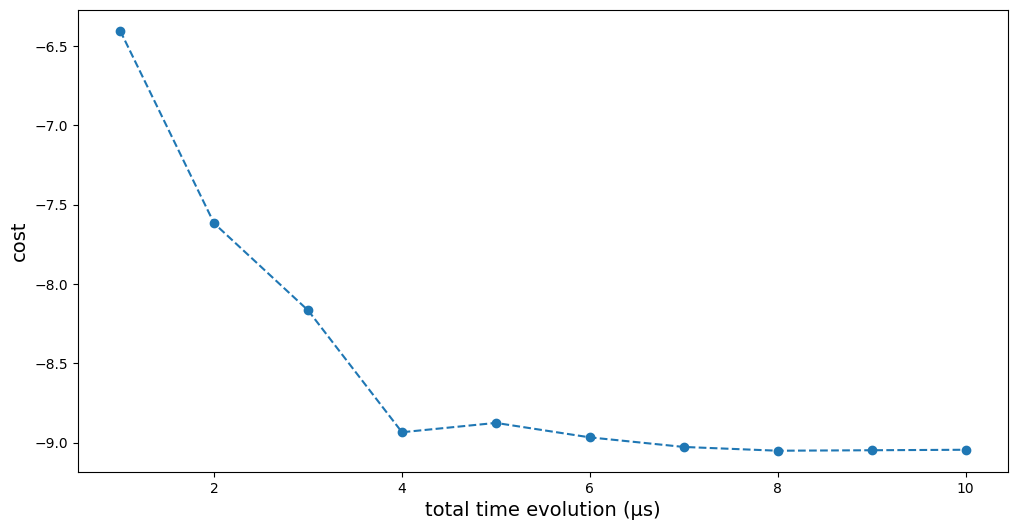

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()